# LDAトピックモデルの作成

In [14]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd

# 分類するトピック数を設定する。
NUM_TOPICS = 6

# カテゴリ数を取得する。
df = pd.read_csv('es_wakati3.csv')

# 訓練データとtestデータに分ける
train_data, test_data = train_test_split(df, test_size=None, train_size=0.8, stratify=df['業種(大分類)'])

all_data = []

# 訓練データの整形
train_texts = []
train_sentenses = train_data['分かち書き'].values
for row in train_sentenses:
    train_texts.append(row.strip().split(' '))
    all_data.append(row.strip().split(' '))

# テストデータの整形
test_texts = []
test_sentenses = test_data['分かち書き'].values
for row in test_sentenses:
    test_texts.append(row.strip().split(' '))
    
# テストデータの原文の整形
test_original_texts = []
test_original_sentenses = test_data[['業種(大分類)','文章']].values
test_original_sentenses_sen = test_data['文章'].values
test_original_sentenses_cat = test_data['業種(大分類)'].values

for row in test_original_sentenses:
    test_original_texts.append(row[0] + ',"' + row[1] + '"')
    all_data.append(row[0] + ',"' + row[1] + '"')

# 訓練データからモデル作成
dictionary = Dictionary(train_texts)
corpus = [dictionary.doc2bow(text) for text in train_texts]
lda_model = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

# テストデータをモデルに掛ける
score_by_topic = defaultdict(int)
test_corpus = [dictionary.doc2bow(text) for text in test_texts]

# クラスタリング結果を出力
with open('lda_result.csv', 'w') as f:
    for unseen_doc, raw_train_text in zip(test_corpus, test_original_texts):
        f.write(raw_train_text + ',')
        for topic, score in lda_model[unseen_doc]:
            score_by_topic[int(topic)] = float(score)
        for i in range(NUM_TOPICS):
            f.write('{:.2f}'.format(score_by_topic[i]) + ',')
        f.write('\n')

In [1]:
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel
from collections import defaultdict
from sklearn.model_selection import train_test_split
import pandas as pd

# 分類するトピック数を設定する。
NUM_TOPICS = 6

# カテゴリ数を取得する。
df = pd.read_csv('tokenized/merge_tokenized.csv')

# 訓練データの整形
texts = []
sentenses = df['tokens'].values
for row in sentenses:
    texts.append(row.strip().split(' '))

# データからモデル作成
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]
lda_model = LdaModel(corpus=corpus, num_topics=NUM_TOPICS, id2word=dictionary)

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [ ]:
# LDAによるトピックモデルを参照してみる。

from sklearn.model_selection import train_test_split
import pandas as pd

df = pd.read_csv('lda_result.csv')
df.head(2)

# LDAトピックモデルのWordCloud

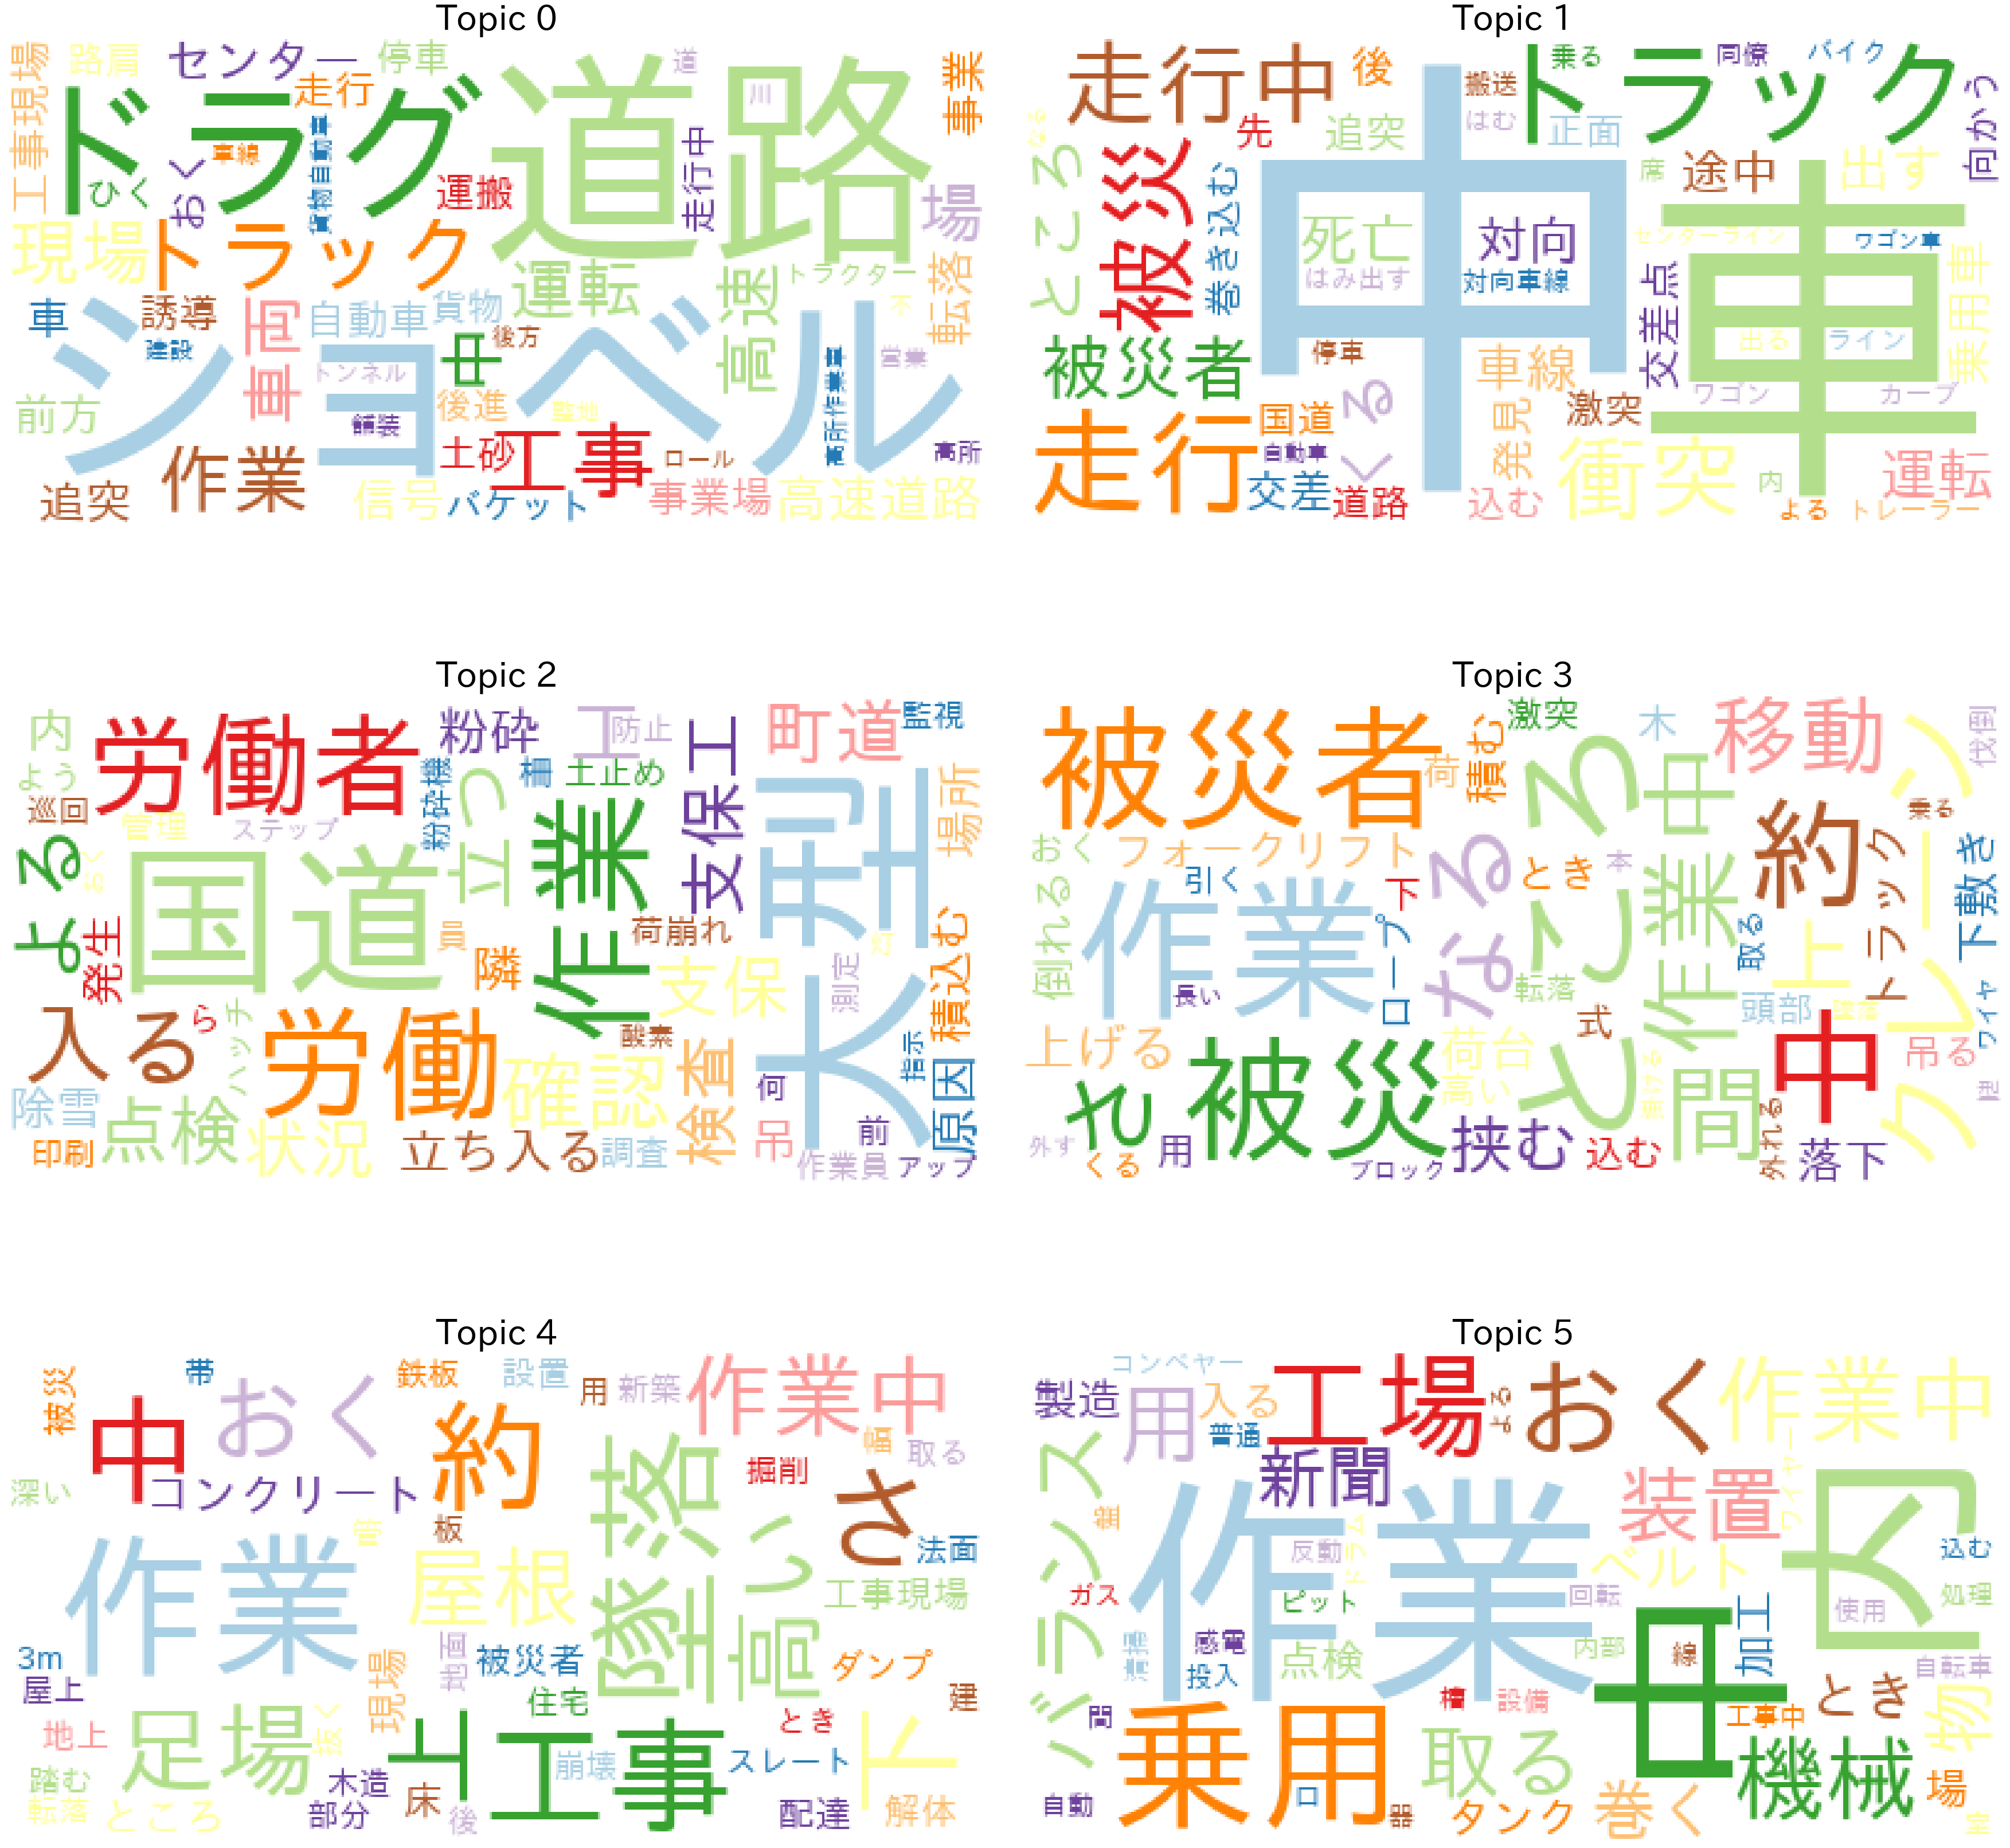

In [2]:
from wordcloud import WordCloud
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams["font.size"] = 50

fig, axs = plt.subplots(ncols=2, nrows=int(lda_model.num_topics/2), figsize=(50,50))
axs = axs.flatten()

def color_func(word, font_size, position, orientation, random_state, font_path):
    return 'darkturquoise'

for i, t in enumerate(range(lda_model.num_topics)):

    x = dict(lda_model.show_topic(t, 50))
    im = WordCloud(
        font_path='/usr/share/fonts/truetype/ipaexg.ttf',
        background_color='white',
        color_func=color_func,
        random_state=0
    ).generate_from_frequencies(x)
    axs[i].imshow(im.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)
    axs[i].axis('off')
    axs[i].set_title('Topic '+str(t))
        
plt.tight_layout()
plt.show()

In [3]:
from tqdm import tqdm
import gensim
from gensim import corpora
from collections import defaultdict

start = 2
limit = 22
step = 1

coherence_vals = []
perplexity_vals = []

for n_topic in tqdm(range(start, limit, step)):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=dictionary, num_topics=n_topic, random_state=0)
    perplexity_vals.append(np.exp2(-lda_model.log_perplexity(corpus)))
    coherence_model_lda = gensim.models.CoherenceModel(model=lda_model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_vals.append(coherence_model_lda.get_coherence())

100%|██████████| 20/20 [20:40<00:00, 62.05s/it]


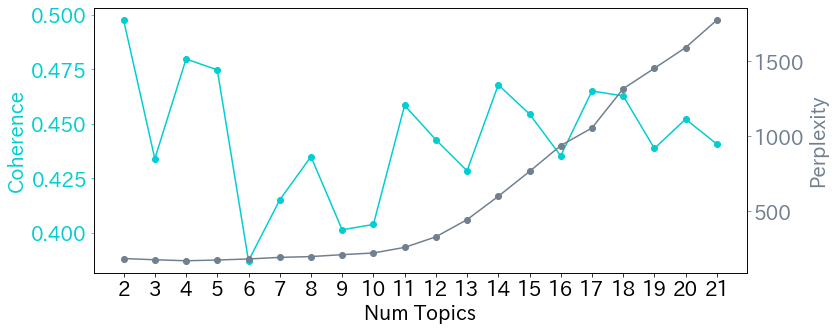

In [6]:
# pyLDAvis
import pyLDAvis
import pyLDAvis.gensim
pyLDAvis.enable_notebook()

plt.rcParams['font.family'] = 'IPAexGothic'
plt.rcParams["font.size"] = 20

x = range(start, limit, step)

fig, ax1 = plt.subplots(figsize=(12,5))

# coherence
c1 = 'darkturquoise'
ax1.plot(x, coherence_vals, 'o-', color=c1)
ax1.set_xlabel('Num Topics')
ax1.set_ylabel('Coherence', color=c1); ax1.tick_params('y', colors=c1)

# perplexity
c2 = 'slategray'
ax2 = ax1.twinx()
ax2.plot(x, perplexity_vals, 'o-', color=c2)
ax2.set_ylabel('Perplexity', color=c2); ax2.tick_params('y', colors=c2)

# Vis
ax1.set_xticks(x)
fig.tight_layout()
plt.show()

In [5]:
import warnings
warnings.filterwarnings('ignore')

# Vis PCoA
lda_model = LdaModel(corpus=corpus, num_topics=5, id2word=dictionary)
vis_pcoa = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary, sort_topics=False)
vis_pcoa

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.091730  0.297809       1        1  14.723414
1     -0.123334 -0.090038       2        1  27.481321
2      0.318110 -0.163892       3        1   9.130945
3     -0.084050  0.040788       4        1  15.024975
4     -0.202457 -0.084667       5        1  33.639351, topic_info=    Category          Freq  Term         Total  loglift  logprob
158  Default  32445.000000  トラック  32445.000000  30.0000  30.0000
735  Default  17066.000000  クレーン  17066.000000  29.0000  29.0000
276  Default  11013.000000     木  11013.000000  28.0000  28.0000
422  Default  20784.000000    墜落  20784.000000  27.0000  27.0000
23   Default  75351.000000    作業  75351.000000  26.0000  26.0000
..       ...           ...   ...           ...      ...      ...
37    Topic5   5783.238281     間  13447.501953   0.2456  -5.2290
796   Topic5   5586.610352    挟む  12179.245117   0.3101  -5.2636
0     Topic5   6097.540527    なる  18119.134766   0.0004  -5.1761
79    Topic5   4954.911621     後   9966.622070   0.3906  -5.3836
23    Topic5   5023.646973    作業  75351.460938  -1.6185  -5.3698

[380 rows x 6 columns], token_table=      Topic      Freq  Term
term                       
742       2  0.927648    3m
742       3  0.023329    3m
742       5  0.048755    3m
1377      2  0.017834     h
1377      4  0.820010     h
...     ...       ...   ...
39        3  0.085471    高い
39        4  0.006068    高い
39        5  0.030862    高い
4550      2  0.999746    高速
4551      2  0.999733  高速道路

[768 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2, 3, 4, 5])